GOOGL 주식 데이터 분석 중...
백테스팅 수행 중...
초기 자본: $10000.00
최종 자산: $17426.88
수익률: 74.27%
거래 횟수: 23


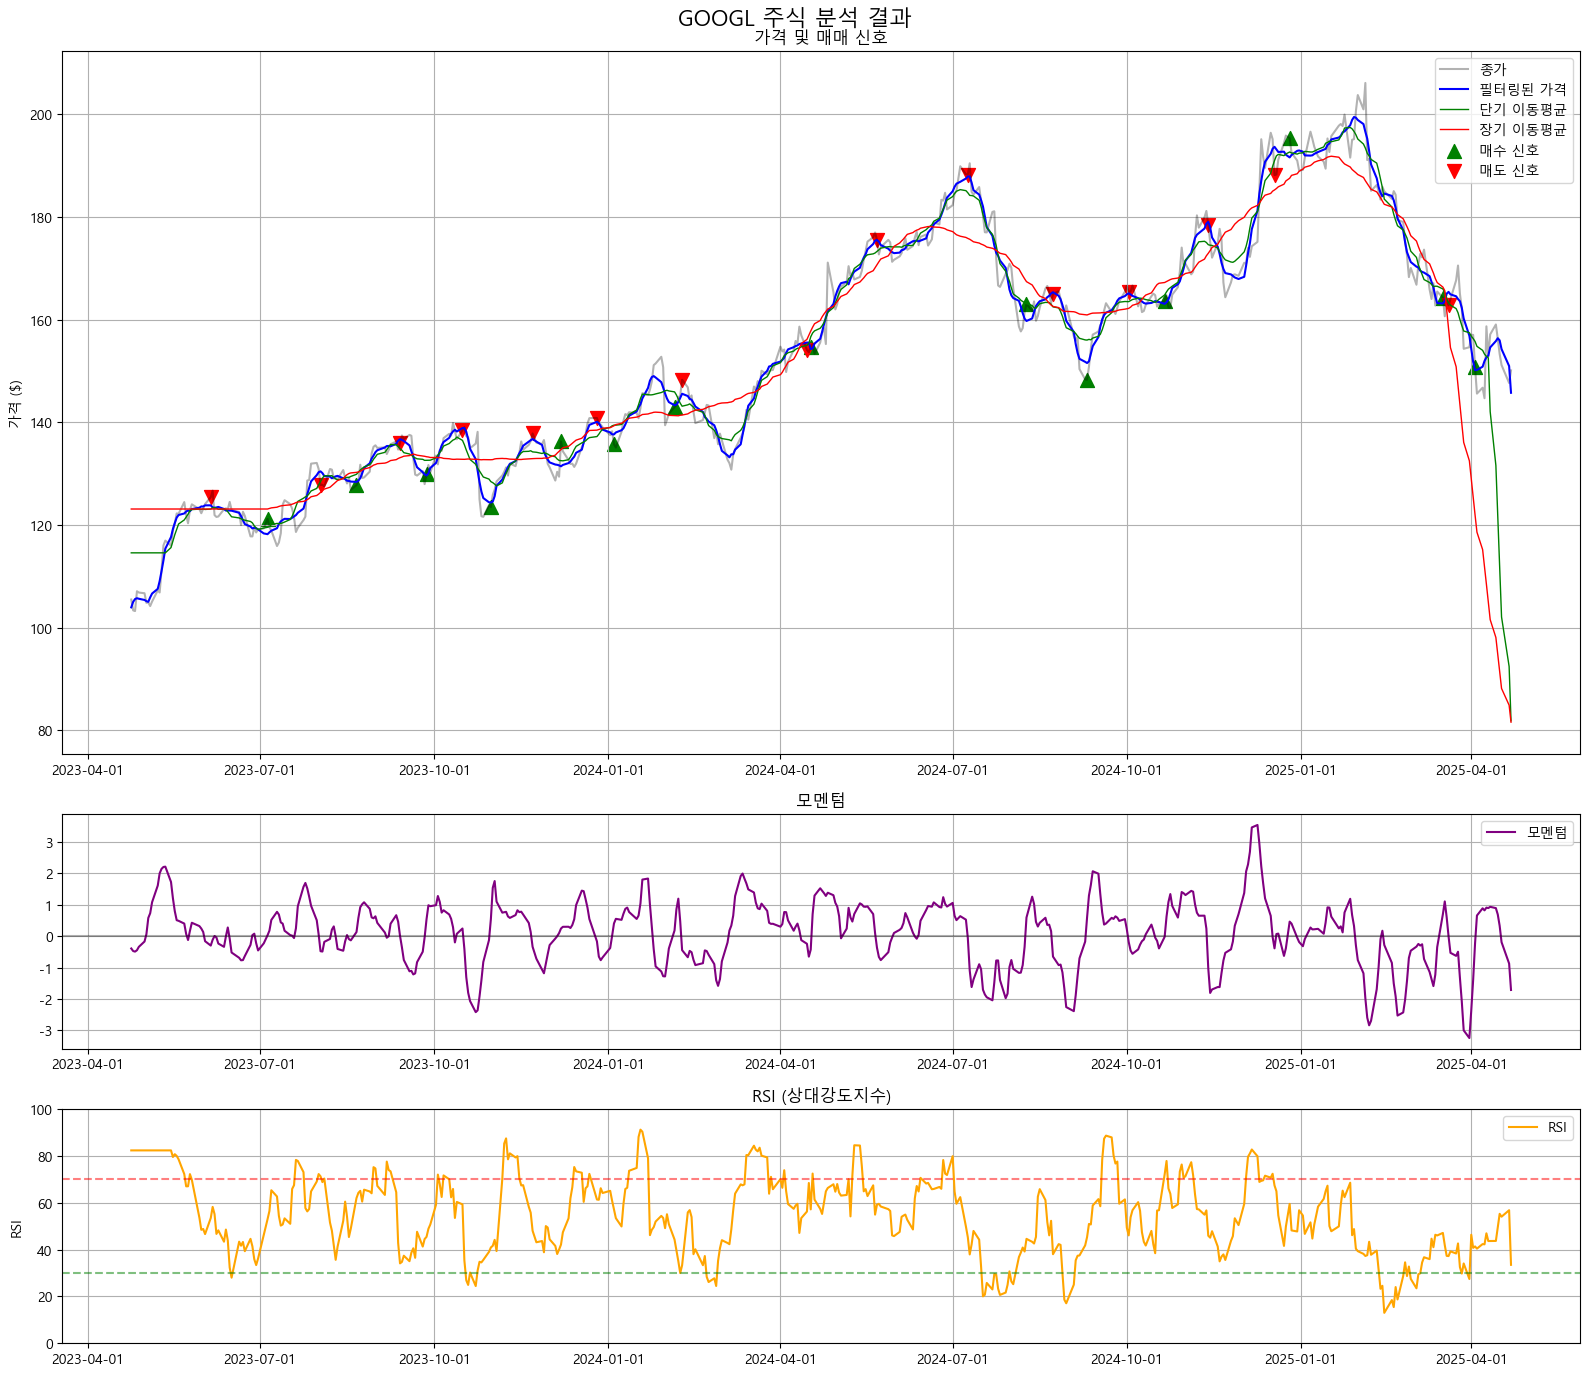

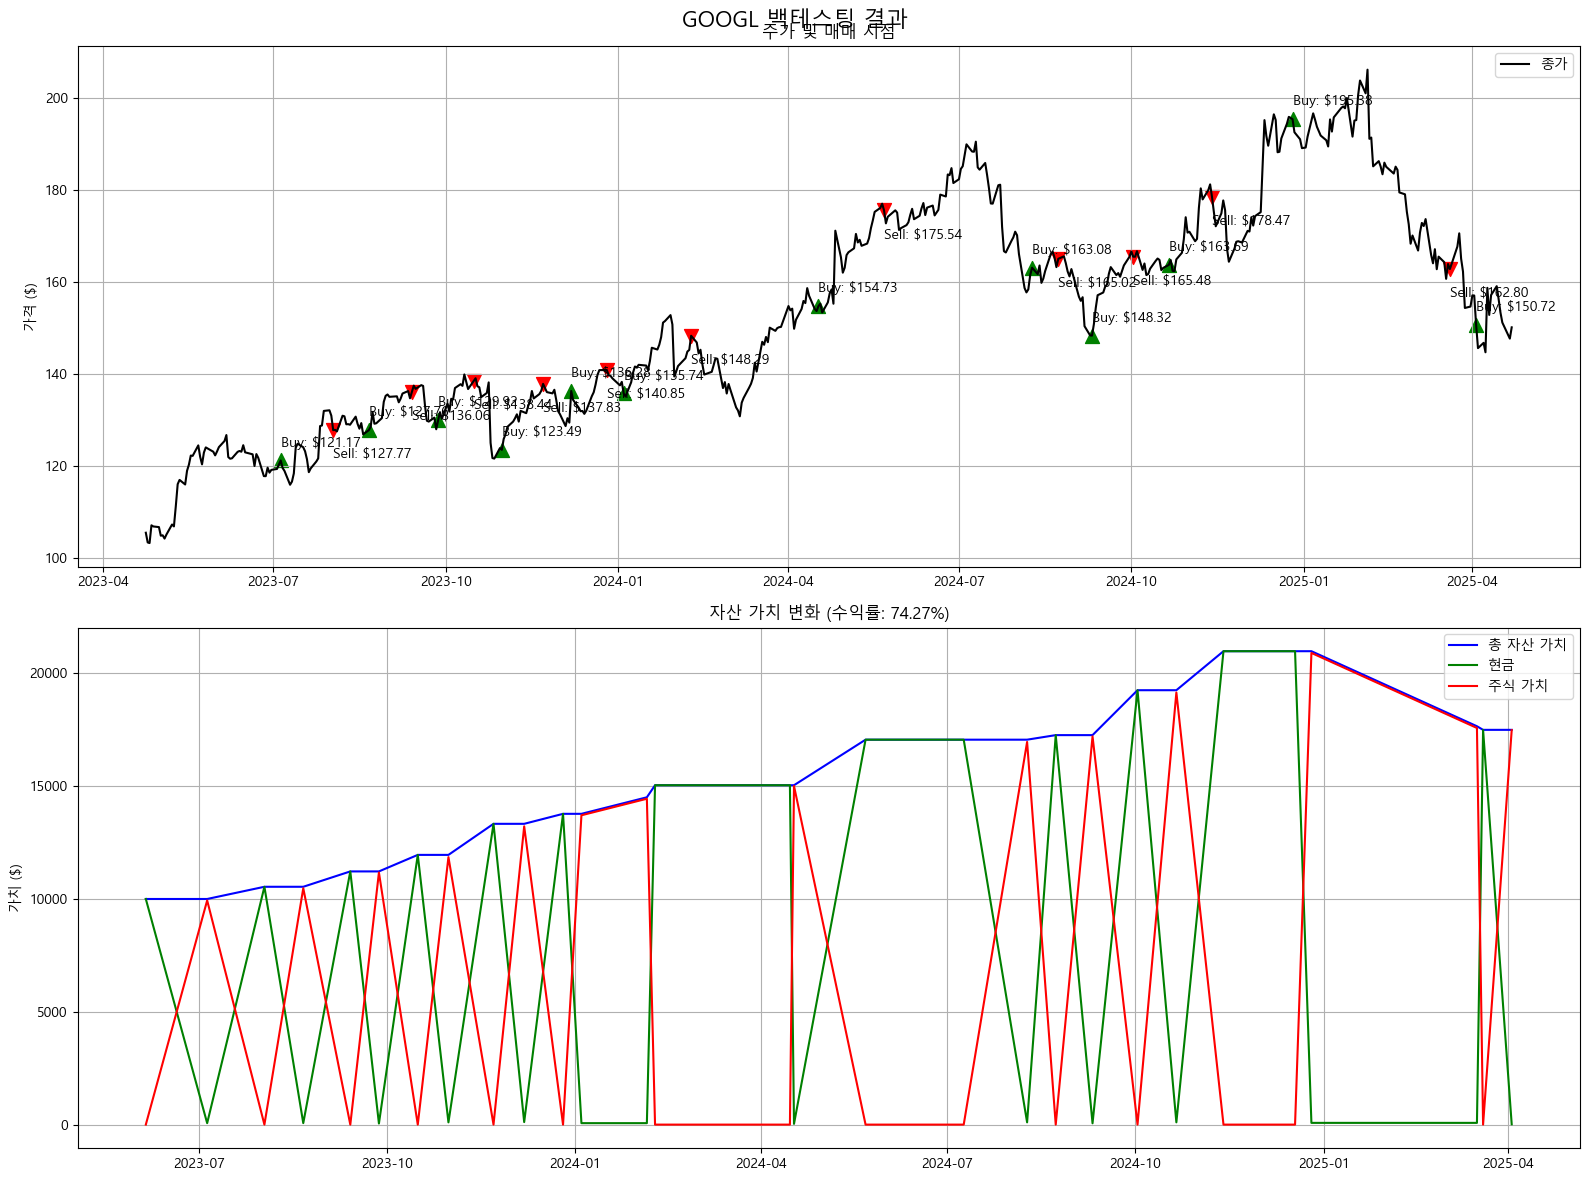

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import signal
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# 1. 야후 파이낸스에서 구글 주식 데이터 가져오기
def get_stock_data(ticker, period='1y'):
    """
    야후 파이낸스에서 주식 데이터를 가져옵니다.
    
    Parameters:
        ticker (str): 주식 티커 심볼 (예: 'GOOGL')
        period (str): 데이터 기간 (예: '1y', '2y', '5y', 'max')
    
    Returns:
        DataFrame: 주식 데이터
    """
    stock = yf.Ticker(ticker)
    df = stock.history(period=period)
    
    # 결측치 처리
    df = df.dropna()
    
    # 날짜 인덱스 재설정
    df = df.reset_index()
    
    return df

# 2. 신호 처리 함수들
def smooth_price(price, window_length=15, polyorder=3):
    """
    Savitzky-Golay 필터를 사용하여 가격 데이터를 부드럽게 합니다.
    """
    return signal.savgol_filter(price, window_length, polyorder)

def calculate_momentum(price, window=14):
    """
    가격 데이터의 모멘텀을 계산합니다.
    """
    momentum = np.gradient(price)
    return signal.savgol_filter(momentum, window, 2)

def detect_peaks_valleys(price, prominence=1, distance=10):
    """
    가격 데이터에서 피크와 골짜기를 탐지합니다.
    """
    peaks, _ = signal.find_peaks(price, prominence=prominence, distance=distance)
    valleys, _ = signal.find_peaks(-price, prominence=prominence, distance=distance)
    
    return peaks, valleys

def calculate_moving_averages(price, short_window=15, long_window=50):
    """
    단기 및 장기 이동평균을 계산합니다.
    """
    short_ma = signal.convolve(price, np.ones(short_window)/short_window, mode='same')
    long_ma = signal.convolve(price, np.ones(long_window)/long_window, mode='same')
    
    # 합성곱 연산으로 인한 경계 효과 처리
    short_ma[:short_window-1] = short_ma[short_window-1]
    long_ma[:long_window-1] = long_ma[long_window-1]
    
    return short_ma, long_ma

def detect_crossovers(short_ma, long_ma):
    """
    골든 크로스와 데드 크로스를 탐지합니다.
    """
    crossover = np.diff(np.sign(short_ma - long_ma))
    buy_signals = np.where(crossover > 0)[0] + 1  # 골든 크로스 (매수 신호)
    sell_signals = np.where(crossover < 0)[0] + 1  # 데드 크로스 (매도 신호)
    
    return buy_signals, sell_signals

def generate_combined_signals(price, momentum, peaks, valleys, mom_peaks, mom_valleys, window=3):
    """
    가격 반전점과 모멘텀 변화를 조합하여 매매 신호를 생성합니다.
    """
    buy_signals = []
    sell_signals = []
    
    # 매수 신호: 가격 골짜기 + 양의 모멘텀
    for valley in valleys:
        # 주변 구간 확인 (윈도우 크기만큼)
        for i in range(-window, window+1):
            if 0 <= valley+i < len(price) and valley+i in mom_peaks:
                buy_signals.append(valley)
                break
    
    # 매도 신호: 가격 피크 + 음의 모멘텀
    for peak in peaks:
        # 주변 구간 확인 (윈도우 크기만큼)
        for i in range(-window, window+1):
            if 0 <= peak+i < len(price) and peak+i in mom_valleys:
                sell_signals.append(peak)
                break
    
    return np.array(buy_signals), np.array(sell_signals)

def calculate_rsi(price, window=14):
    """
    상대강도지수(RSI)를 계산합니다.
    """
    delta = np.diff(price)
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    down = abs(down)
    
    # 윈도우 크기만큼의 이동평균 계산
    up_avg = np.convolve(up, np.ones(window)/window, mode='same')
    down_avg = np.convolve(down, np.ones(window)/window, mode='same')
    
    # 첫 부분 채우기
    up_avg[:window] = up_avg[window]
    down_avg[:window] = down_avg[window]
    
    # RSI 계산
    rs = up_avg / (down_avg + 1e-10)  # 0으로 나누기 방지
    rsi = 100 - (100 / (1 + rs))
    
    # 원래 길이와 맞추기 위해 첫 값 복제
    rsi = np.insert(rsi, 0, rsi[0])
    
    return rsi

# 3. 주요 분석 함수
def analyze_stock(ticker, period='1y'):
    """
    주식 데이터를 분석하고 매매 신호를 생성합니다.
    """
    # 주식 데이터 가져오기
    df = get_stock_data(ticker, period)
    
    # 종가 데이터 추출
    price = df['Close'].values
    dates = df['Date'].values
    
    # 1. 노이즈 제거
    smoothed_price = smooth_price(price, window_length=15, polyorder=3)
    
    # 2. 이동평균 계산
    short_ma, long_ma = calculate_moving_averages(price)
    
    # 3. 모멘텀 계산
    momentum = calculate_momentum(price)
    
    # 4. 피크와 골짜기 탐지
    peaks, valleys = detect_peaks_valleys(smoothed_price)
    
    # 5. 모멘텀 변화 탐지
    mom_peaks, _ = signal.find_peaks(momentum, height=0)
    mom_valleys, _ = signal.find_peaks(-momentum, height=0)
    
    # 6. 이동평균 크로스오버 탐지
    ma_buy, ma_sell = detect_crossovers(short_ma, long_ma)
    
    # 7. 결합된 매매 신호 생성
    buy_signals, sell_signals = generate_combined_signals(
        smoothed_price, momentum, peaks, valleys, mom_peaks, mom_valleys)
    
    # 8. RSI 계산
    rsi = calculate_rsi(price)
    
    # 결과 반환
    results = {
        'df': df,
        'price': price,
        'smoothed_price': smoothed_price,
        'dates': dates,
        'short_ma': short_ma,
        'long_ma': long_ma,
        'momentum': momentum,
        'peaks': peaks,
        'valleys': valleys,
        'ma_buy': ma_buy,
        'ma_sell': ma_sell,
        'buy_signals': buy_signals,
        'sell_signals': sell_signals,
        'rsi': rsi
    }
    
    return results

# 4. 결과 시각화 함수
def plot_results(results, ticker):
    """
    분석 결과를 시각화합니다.
    """
    df = results['df']
    dates = df['Date']
    price = results['price']
    smoothed_price = results['smoothed_price']
    short_ma = results['short_ma']
    long_ma = results['long_ma']
    momentum = results['momentum']
    buy_signals = results['buy_signals']
    sell_signals = results['sell_signals']
    rsi = results['rsi']
    
    # 그래프 설정
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 14), gridspec_kw={'height_ratios': [3, 1, 1]})
    fig.suptitle(f'{ticker} 주식 분석 결과', fontsize=16)
    
    # 1. 가격 및 이동평균 차트
    ax1.plot(dates, price, 'k-', label='종가', alpha=0.3)
    ax1.plot(dates, smoothed_price, 'b-', label='필터링된 가격', linewidth=1.5)
    ax1.plot(dates, short_ma, 'g-', label='단기 이동평균', linewidth=1)
    ax1.plot(dates, long_ma, 'r-', label='장기 이동평균', linewidth=1)
    
    # 매매 신호 표시
    ax1.scatter(dates[buy_signals], price[buy_signals], marker='^', color='g', s=100, label='매수 신호')
    ax1.scatter(dates[sell_signals], price[sell_signals], marker='v', color='r', s=100, label='매도 신호')
    
    # 그래프 설정
    ax1.set_title('가격 및 매매 신호')
    ax1.set_ylabel('가격 ($)')
    ax1.grid(True)
    ax1.legend(loc='best')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    # 2. 모멘텀 차트
    ax2.plot(dates, momentum, 'purple', label='모멘텀')
    ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax2.set_title('모멘텀')
    ax2.grid(True)
    ax2.legend(loc='best')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    # 3. RSI 차트
    ax3.plot(dates, rsi, 'orange', label='RSI')
    ax3.axhline(y=70, color='r', linestyle='--', alpha=0.5)
    ax3.axhline(y=30, color='g', linestyle='--', alpha=0.5)
    ax3.set_title('RSI (상대강도지수)')
    ax3.set_ylabel('RSI')
    ax3.set_ylim([0, 100])
    ax3.grid(True)
    ax3.legend(loc='best')
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    
    return fig

# 5. 백테스팅 함수
def backtest_strategy(results, initial_capital=10000):
    """
    매매 신호에 기반한 간단한 백테스팅을 수행합니다.
    """
    df = results['df']
    price = df['Close'].values
    buy_signals = results['buy_signals']
    sell_signals = results['sell_signals']
    
    # 전체 신호를 시간순으로 정렬
    all_signals = [(idx, 'buy') for idx in buy_signals] + [(idx, 'sell') for idx in sell_signals]
    all_signals.sort(key=lambda x: x[0])
    
    capital = initial_capital
    shares = 0
    trades = []
    positions = []
    
    for idx, signal_type in all_signals:
        date = df['Date'].iloc[idx]
        current_price = price[idx]
        
        if signal_type == 'buy' and capital > current_price:
            # 가능한 모든 주식 구매
            max_shares = capital // current_price
            cost = max_shares * current_price
            shares += max_shares
            capital -= cost
            
            trades.append({
                'date': date,
                'type': 'buy',
                'price': current_price,
                'shares': max_shares,
                'cost': cost,
                'capital': capital
            })
            
        elif signal_type == 'sell' and shares > 0:
            # 모든 주식 판매
            profit = shares * current_price
            capital += profit
            
            trades.append({
                'date': date,
                'type': 'sell',
                'price': current_price,
                'shares': shares,
                'profit': profit,
                'capital': capital
            })
            
            shares = 0
        
        # 현재 포지션 (시간 경과에 따른 자산 가치)
        positions.append({
            'date': date,
            'capital': capital,
            'shares': shares,
            'share_value': shares * current_price,
            'total_value': capital + (shares * current_price)
        })
    
    # 마지막 가격으로 최종 자산 평가
    final_value = capital + (shares * price[-1])
    return_pct = (final_value - initial_capital) / initial_capital * 100
    
    results = {
        'initial_capital': initial_capital,
        'final_value': final_value,
        'return_pct': return_pct,
        'trades': trades,
        'positions': positions
    }
    
    return results

# 6. 백테스팅 결과 시각화
def plot_backtest_results(backtest_results, results, ticker):
    """
    백테스팅 결과를 시각화합니다.
    """
    df = results['df']
    dates = df['Date']
    price = results['price']
    
    # 포지션을 데이터프레임으로 변환
    if backtest_results['positions']:
        positions_df = pd.DataFrame(backtest_results['positions'])
        
        # 날짜를 datetime으로 변환
        positions_df['date'] = pd.to_datetime(positions_df['date'])
        
        # 그래프 설정
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
        fig.suptitle(f'{ticker} 백테스팅 결과', fontsize=16)
        
        # 1. 가격 차트와 매수/매도 시점
        ax1.plot(dates, price, 'k-', label='종가')
        
        # 매수/매도 거래 표시
        for trade in backtest_results['trades']:
            if trade['type'] == 'buy':
                ax1.scatter(trade['date'], trade['price'], marker='^', color='g', s=100)
                ax1.annotate(f"Buy: ${trade['price']:.2f}", 
                            (trade['date'], trade['price']), 
                            xytext=(0, 10), 
                            textcoords='offset points')
            else:
                ax1.scatter(trade['date'], trade['price'], marker='v', color='r', s=100)
                ax1.annotate(f"Sell: ${trade['price']:.2f}", 
                            (trade['date'], trade['price']), 
                            xytext=(0, -20), 
                            textcoords='offset points')
        
        ax1.set_title('주가 및 매매 시점')
        ax1.set_ylabel('가격 ($)')
        ax1.grid(True)
        ax1.legend(loc='best')
        
        # 2. 자산 가치 변화
        ax2.plot(positions_df['date'], positions_df['total_value'], 'b-', label='총 자산 가치')
        ax2.plot(positions_df['date'], positions_df['capital'], 'g-', label='현금')
        ax2.plot(positions_df['date'], positions_df['share_value'], 'r-', label='주식 가치')
        
        ax2.set_title(f'자산 가치 변화 (수익률: {backtest_results["return_pct"]:.2f}%)')
        ax2.set_ylabel('가치 ($)')
        ax2.grid(True)
        ax2.legend(loc='best')
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        
        return fig
    else:
        print("포지션 정보가 없습니다.")
        return None

# 7. 메인 실행 함수
def main():
    # 분석할 주식 티커
    ticker = 'GOOGL'  # 구글(Alphabet Inc.)
    
    # 데이터 가져오기 및 분석
    print(f"{ticker} 주식 데이터 분석 중...")
    results = analyze_stock(ticker, period='2y')
    
    # 결과 시각화
    fig1 = plot_results(results, ticker)
    fig1.savefig(f'{ticker}_analysis.png')
    
    # 백테스팅
    print("백테스팅 수행 중...")
    backtest_results = backtest_strategy(results, initial_capital=10000)
    
    # 백테스팅 결과 출력
    print(f"초기 자본: ${backtest_results['initial_capital']:.2f}")
    print(f"최종 자산: ${backtest_results['final_value']:.2f}")
    print(f"수익률: {backtest_results['return_pct']:.2f}%")
    print(f"거래 횟수: {len(backtest_results['trades'])}")
    
    # 백테스팅 결과 시각화
    fig2 = plot_backtest_results(backtest_results, results, ticker)
    if fig2:
        fig2.savefig(f'{ticker}_backtest.png')
    
    plt.show()

main()